In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import Model
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from models.dcec import DCEC
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 28, 28
batch_size = 128
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [3]:
dcec = DCEC()
dcec.compile(optimizer='sgd',
              loss='mse')
dcec.fit(mnist_train_data, 
         mnist_train_data, 
         batch_size=batch_size, 
         epochs=100,
         verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 350s 6ms/step - loss: 0.1108
Epoch 2/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.1086
Epoch 3/100
60000/60000 [==============================] - 339s 6ms/step - loss: 0.1067
Epoch 4/100
60000/60000 [==============================] - 336s 6ms/step - loss: 0.1051
Epoch 5/100
60000/60000 [==============================] - 331s 6ms/step - loss: 0.1037
Epoch 6/100
60000/60000 [==============================] - 332s 6ms/step - loss: 0.1025
Epoch 7/100
60000/60000 [==============================] - 331s 6ms/step - loss: 0.1014
Epoch 8/100
60000/60000 [==============================] - 336s 6ms/step - loss: 0.1005
Epoch 9/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0997
Epoch 10/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0990

Epoch 87/100
60000/60000 [==============================] - 332s 6ms/step - loss: 0.0946
Epoch 88/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 89/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 90/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 91/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 92/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 93/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 94/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 95/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0946
Epoch 96/100
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0945
Epoch 97/100
60000/60000 [==============================] - 336s 6ms/step - loss: 0.0945
Epoch 98/100
60000/60

In [4]:
#encoder = Model(inputs=dcec.layers[0].input, outputs=dcec.get_layer(name='dense1').output)
embed = keras.backend.function([dcec.layers[0].input],
                                              [dcec.get_layer(name='dense1').output])
embeddings = np.asarray(embed(mnist_train_data)).squeeze(0)
normalizer = Normalizer(norm='l2')
#embeddings = encoder.predict(mnist_train_data)

print(f'Embeddings shape: {embeddings.shape}')
embeddings = normalizer.fit_transform(embeddings)
clusters = KMeans(n_clusters=10).fit_transform(embeddings)
print(f'Clusters shape: {clusters.shape}')

Embeddings shape: (60000, 10)
Clusters shape: (60000, 10)


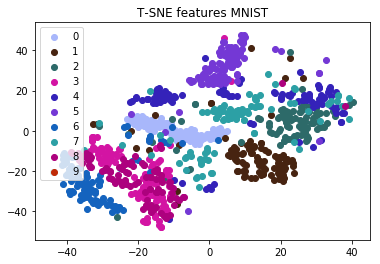

In [5]:
def plot_tsne(data: np.ndarray,
              labels: np.ndarray,
              dataset_name: np.ndarray,
              num_samples_per_class: int = 100) -> None:
    unique_labels = np.unique(labels)
    x_tsne = np.array([])
    for i in range(len(unique_labels)):
        label_ix = np.argwhere(unique_labels[i] == labels).flatten()
        random_labels_ix = np.random.choice(label_ix, num_samples_per_class)
        random_label_data = data[random_labels_ix, :]
        random_label_data = np.reshape(random_label_data, (num_samples_per_class, -1))
        if i == 0:
            x_tsne = random_label_data
        else:
            x_tsne = np.vstack((x_tsne, random_label_data))
    tsne_emb = TSNE(n_components=2).fit_transform(x_tsne)
    for i in range(len(unique_labels)):
        rgb = np.random.rand(3,)
        start_slice = (i+1)*num_samples_per_class
        stop_slice = (i+2)*num_samples_per_class
        x_plot = tsne_emb[()]
        plt.scatter(tsne_emb[start_slice:stop_slice, 0], tsne_emb[start_slice:stop_slice,1], c=[rgb])
    plt.title(f'T-SNE features {dataset_name}')
    plt.legend(unique_labels)
    plt.show()
    
plot_tsne(mnist_train_data, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

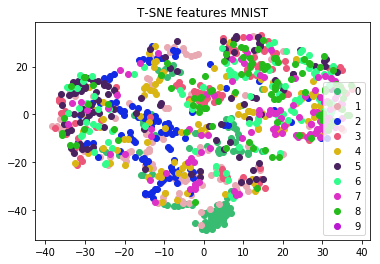

In [6]:
plot_tsne(clusters, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

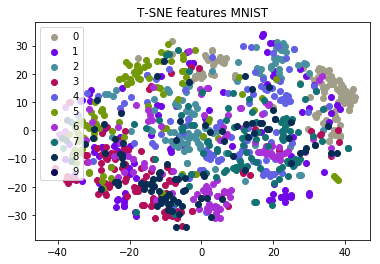

In [7]:
plot_tsne(embeddings, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

In [ ]:
dcec_adam = DCEC()
dcec_adam.compile(optimizer='adam',
                  loss='mse')
dcec_adam.fit(mnist_train_data, 
              mnist_train_data, 
              batch_size=batch_size, 
              epochs=100,
              verbose=1)

Epoch 1/100
60000/60000 [==============================] - 343s 6ms/step - loss: 0.0391
Epoch 2/100
60000/60000 [==============================] - 339s 6ms/step - loss: 0.0207
Epoch 3/100
60000/60000 [==============================] - 340s 6ms/step - loss: 0.0177
Epoch 4/100
60000/60000 [==============================] - 340s 6ms/step - loss: 0.0163
Epoch 5/100
60000/60000 [==============================] - 337s 6ms/step - loss: 0.0154
Epoch 6/100
60000/60000 [==============================] - 342s 6ms/step - loss: 0.0147
Epoch 7/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0142
Epoch 8/100
60000/60000 [==============================] - 339s 6ms/step - loss: 0.0138
Epoch 9/100
60000/60000 [==============================] - 342s 6ms/step - loss: 0.0134
Epoch 10/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0131
Epoch 11/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0129
Epoch 12/100
60000/60000 [====

In [ ]:
#encoder = Model(inputs=dcec.layers[0].input, outputs=dcec.get_layer(name='dense1').output)
embed = keras.backend.function([dcec_adam.layers[0].input],
                                              [dcec_adam.get_layer(name='dense1').output])
embeddings = np.asarray(embed(mnist_train_data)).squeeze(0)
normalizer = Normalizer(norm='l2')
#embeddings = encoder.predict(mnist_train_data)

print(f'Embeddings shape: {embeddings.shape}')
embeddings = normalizer.fit_transform(embeddings)
clusters = KMeans(n_clusters=10).fit_transform(embeddings)
print(f'Clusters shape: {clusters.shape}')

In [ ]:
plot_tsne(clusters, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

In [ ]:
plot_tsne(embeddings, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)